<a href="https://colab.research.google.com/github/manushiez/Iris-Detection---test-2/blob/main/IDR_TEST_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analysing /content/S2002R01.jpg


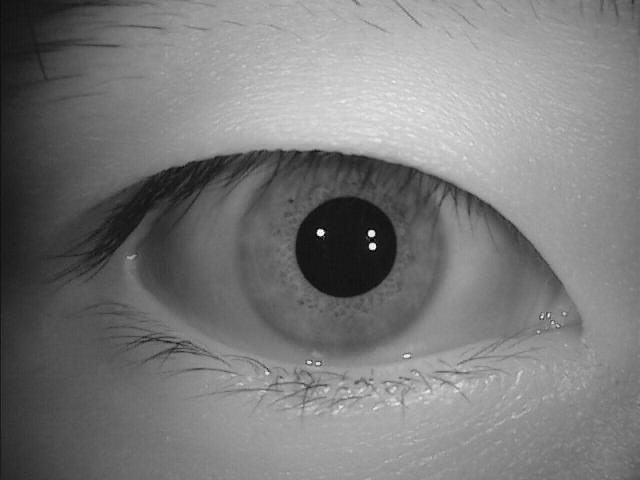

Analysing /content/S2005R07.jpg


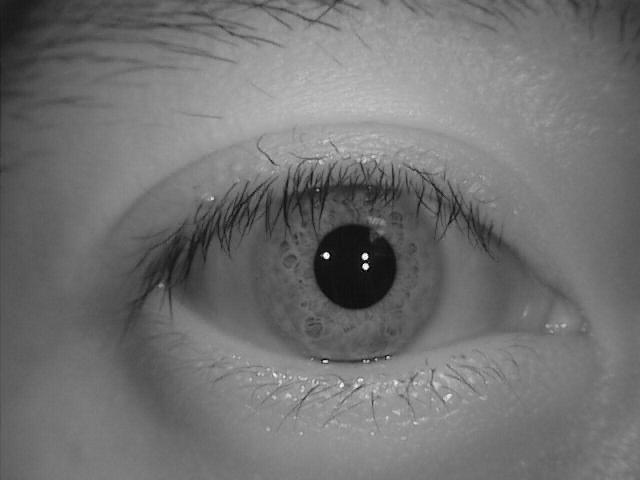

Getting iris boundaries for right-side


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [ ]:
import numpy as np
import cv2
import os
import sys
import math
import random
import pickle
import copy
import gzip
import inspect
import itertools

from matplotlib import pyplot as plt


from google.colab.patches import cv2_imshow

def compare_images(filepath1, filepath2):
    print("Analysing", filepath1)
    if os.path.isfile(filepath1):
        img1 = load_image(filepath1, show=True)
    else:
        print("File not found:", filepath1)
        return

    print("Analysing", filepath2)
    if os.path.isfile(filepath2):
        img2 = load_image(filepath2, show=True)
    else:
        print("File not found:", filepath2)
        return

    rois_1 = load_rois_from_image(img1)
    rois_2 = load_rois_from_image(img2)

    getall_matches(rois_1, rois_2, 0.8, 10, 0.15, show=True)

def compare_binfiles(bin_path1, bin_path2):
    print("Analysing " + bin_path1)
    rois_1 = load_rois_from_bin(bin_path1)

    print("Analysing " + bin_path2)
    rois_2 = load_rois_from_bin(bin_path2)

    getall_matches(rois_1, rois_2, 0.88, 10, 0.07, show=True)

def load_rois_from_image(img):
    rois = {}
    for pos in ['right-side', 'left-side', 'bottom', 'complete']:
        print("Getting iris boundaries for", pos)
        rois[pos] = get_iris_boundaries(img, show=True)

    return rois

def load_image(filepath, show=False):
    if os.path.isfile(filepath):
        img = cv2.imread(filepath, 0)
        if show:
            cv2_imshow(img)
        return img
    else:
        print("File not found:", filepath)
        return None

def get_iris_boundaries(img, show=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY_INV)


    circles = cv2.HoughCircles(thresholded, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=30, minRadius=10, maxRadius=200)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]


            cv2.circle(img, center, radius, (0, 255, 0), 2)


            iris_region = img[center[1]-radius:center[1]+radius, center[0]-radius:center[0]+radius]

            if show:
                cv2.imshow('Iris Region', iris_region)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

            return iris_region, (center[0], center[1]), radius
    else:
        print('ERROR: Pupil circle not found!')
        ext_iris_circle = None

def find_pupil(img):
    def get_edges(image):
        edges = cv2.Canny(image,20,100)
        kernel = np.ones((3,3),np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=2)
        ksize = 2 * random.randrange(5,11) + 1
        edges = cv2.GaussianBlur(edges,(ksize,ksize),0)
        return edges

    param1 = 200 # 200
    param2 = 120 # 150
    pupil_circles = []
    while(param2 > 35 and len(pupil_circles) < 100):
        for mdn,thrs in [(m,t)
                         for m in [3,5,7]
                         for t in [20,25,30,35,40,45,50,55,60]]:

            median = cv2.medianBlur(img, 2*mdn+1)

            ret, thres = cv2.threshold(
                            median, thrs, 255,
                            cv2.THRESH_BINARY_INV)

            con_img, contours, hierarchy = \
                    cv2.findContours(thres.copy(),
                                     cv2.RETR_EXTERNAL,
                                     cv2.CHAIN_APPROX_NONE)
            draw_con = cv2.drawContours(thres, contours, -1, (255), -1)

            edges = get_edges(thres)

            circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 1,
                                       np.array([]), param1, param2)
            if circles is not None:

                circles = np.round(circles[0, :]).astype("int")
                for c in circles:
                    pupil_circles.append(c)

        param2 = param2 -1

    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

    return get_mean_circle(pupil_circles)

def get_mean_circle(circles, draw=None):
    if not circles:
        return
    mean_0 = int(np.mean([c[0] for c in circles]))
    mean_1 = int(np.mean([c[1] for c in circles]))
    mean_2 = int(np.mean([c[2] for c in circles]))

    if draw is not None:
        draw = draw.copy()

        cv2.circle(draw,(mean_0,mean_1),mean_2,(0,255,0),1)

        cv2.circle(draw,(mean_0,mean_1),2,(0,255,0),2)
        cv2.imshow('mean circle', draw)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()

    return mean_0, mean_1, mean_2

def find_ext_iris(img, pupil_circle, center_range, radius_range):
    def get_edges(image, thrs2):
        thrs1 = 0 # 0
        edges = cv2.Canny(image, thrs1, thrs2, apertureSize=5)
        kernel = np.ones((3,3),np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=1)
        ksize = 2 * random.randrange(5,11) + 1
        edges = cv2.GaussianBlur(edges,(ksize,ksize),0)
        return edges

    def get_circles(hough_param, median_params, edge_params):
        crt_circles = []
        for mdn,thrs2 in [(m,t)
                          for m in median_params
                          for t in edge_params]:

            median = cv2.medianBlur(img, 2*mdn+1)


            edges = get_edges(median, thrs2)


            circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 1,
                                       np.array([]), 200, hough_param)
            if circles is not None:

                circles = np.round(circles[0, :]).astype("int")
                for (c_col, c_row, r) in circles:
                    if point_in_circle(
                            int(pupil_circle[0]), int(pupil_circle[1]),
                            center_range, c_col, c_row) and \
                       r > radius_range:
                        crt_circles.append((c_col, c_row, r))
        return crt_circles

    param2 = 120 # 150
    total_circles = []
    while(param2 > 40 and len(total_circles) < 50):
        crt_circles = get_circles(
                        param2, [8,10,12,14,16,18,20], [430,480,530])
        if crt_circles:
            total_circles += crt_circles
        param2 = param2 -1

    if not total_circles:
        print("Running plan B on finding ext iris circle")
        param2 = 120
        while(param2 > 40 and len(total_circles) < 50):
            crt_circles = get_circles(
                            param2, [3,5,7,21,23,25], [430,480,530])
            if crt_circles:
                total_circles += crt_circles
            param2 = param2 -1

    if not total_circles:
        return

    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    filtered = filtered_circles(total_circles)

    return get_mean_circle(filtered)

def point_in_circle(c_col, c_row, c_radius, p_col, p_row):
    return distance(c_col, c_row, p_col, p_row) <= c_radius

def filtered_circles(circles, draw=None):

    def get_alpha_radius(circles0):
        alpha_circle = None
        dist_min = None
        circles1 = circles0[:]
        circles2 = circles0[:]
        for crt_c in circles1:
            dist = 0
            for c in circles2:
                dist += math.fabs(float(crt_c[2]) - float(c[2]))
            if not dist_min or dist < dist_min:
                dist_min = dist
                alpha_circle = crt_c
        return alpha_circle[2]

    if not circles:
        print('Error: empty circles list in filtered_circles() !')
        return []
    c_1_mean, c_1_dev = standard_dev([int(i[1]) for i in circles])
    filtered = []
    filtered_pos = []
    not_filtered = []
    ratio = 1.5
    for c in circles[:]:
        if c[0] < c_0_mean - ratio*c_0_dev or \
           c[0] > c_0_mean + ratio*c_0_dev or \
           c[1] < c_1_mean - ratio*c_1_dev or \
           c[1] > c_1_mean + ratio*c_1_dev:
            not_filtered.append(c)
        else:
            filtered_pos.append(c)
    if len([float(c[2]) for c in filtered_pos]) < 3:
        filtered = filtered_pos
    else:
        alpha_radius = get_alpha_radius(filtered_pos)
        mean_radius, dev_radius = standard_dev(
                                    [float(c[2]) for c in filtered_pos])
        max_radius = alpha_radius + dev_radius
        min_radius = alpha_radius - dev_radius
        for c in filtered_pos:
            if c[2] < min_radius or \
               c[2] > max_radius:
                not_filtered.append(c)
            else:
                filtered.append(c)

    if draw is not None:
        draw = draw.copy()
        for circle in not_filtered:

            cv2.circle(draw,(circle[0],circle[1]),circle[2],(255,0,0),1)

            cv2.circle(draw,(circle[0],circle[1]),2,(255,0,0),2)
        for circle in filtered:

            cv2.circle(draw,(circle[0],circle[1]),circle[2],(0,255,0),1)

            cv2.circle(draw,(circle[0],circle[1]),2,(0,255,0),2)
        cv2.imshow('filtered_circles() total={0} filtered_pos={1} filtered={2}'.\
                   format(len(circles), len(filtered_pos), len(filtered)),
                   draw)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()
    return filtered

def draw_circles(cimg, pupil_circle, ext_iris_circle,
                 center_range=None, radius_range=None):

    cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), pupil_circle[2],
                     (0,0,255),1)

    cv2.circle(cimg,(pupil_circle[0],pupil_circle[1]),1,(0,0,255),1)
    if center_range:

        cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), center_range,
                         (0,255,255),1)
    if radius_range:

        cv2.circle(cimg,(pupil_circle[0], pupil_circle[1]), radius_range,
                         (0,255,255),1)

    cv2.circle(cimg, (ext_iris_circle[0], ext_iris_circle[1]),
               ext_iris_circle[2],(0,255,0),1)

    cv2.circle(cimg, (ext_iris_circle[0], ext_iris_circle[1]),
               1,(0,255,0),1)

def get_equalized_iris(img, ext_iris_circle, pupil_circle, show=False):
    def find_roi():
        mask = img.copy()
        mask[:] = (0)

        cv2.circle(mask,
                   (ext_iris_circle[0], ext_iris_circle[1]),
                   ext_iris_circle[2], (255), -1)
        cv2.circle(mask,
                   (pupil_circle[0],pupil_circle[1]),
                   pupil_circle[2],(0), -1)

        roi = cv2.bitwise_and(img, mask)

        return roi

    roi = find_roi()


    for p_col in range(roi.shape[1]):
        for p_row in range(roi.shape[0]):
            theta = angle_v(ext_iris_circle[0], ext_iris_circle[1],
                            p_col, p_row)
            if theta > 50 and theta < 130:
                roi[p_row,p_col] = 0

    ret, roi = cv2.threshold(roi,50,255,cv2.THRESH_TOZERO)

    equ_roi = roi.copy()
    cv2.equalizeHist(roi, equ_roi)
    roi = cv2.addWeighted(roi, 0.0, equ_roi, 1.0, 0)

    if show:
        cv2.imshow('equalized histogram iris region', roi)
        ch = cv2.waitKey(0)
        cv2.destroyAllWindows()

    return roi

def get_rois(img, pupil_circle, ext_circle, show=False):
    bg = img.copy()
    bg[:] = 0

    init_dict = {'img': bg.copy(),
                 'pupil_circle': pupil_circle,
                 'ext_circle': ext_circle,
                 'kp': None,
                 'img_kp_init': bg.copy(),
                 'img_kp_filtered': bg.copy(),
                 'des': None
                 }

    rois = {'right-side': copy.deepcopy(init_dict),
            'left-side': copy.deepcopy(init_dict),
            'bottom': copy.deepcopy(init_dict),
            'complete': copy.deepcopy(init_dict)
            }

    for p_col in range(img.shape[1]):
        for p_row in range(img.shape[0]):
            if not point_in_circle(pupil_circle[0], pupil_circle[1],
                                   pupil_circle[2], p_col, p_row) and \
               point_in_circle(ext_circle[0], ext_circle[1], ext_circle[2],
                                   p_col, p_row):
                theta = angle_v(ext_circle[0], ext_circle[1], p_col, p_row)
                if theta >= -50 and theta <= 50:
                    rois['right-side']['img'][p_row,p_col] = img[p_row,p_col]
                if theta >= 130 or theta <= -130:
                    rois['left-side']['img'][p_row,p_col] = img[p_row,p_col]
                if theta >= -140 and theta <= -40:
                    rois['bottom']['img'][p_row,p_col] = img[p_row,p_col]
                rois['complete']['img'][p_row,p_col] = img[p_row,p_col]

    rois['right-side']['ext_circle'] = \
            (0, int(1.25*ext_circle[2]), int(ext_circle[2]))
    rois['left-side']['ext_circle'] = \
            (int(1.25*ext_circle[2]),
             int(1.25*ext_circle[2]),
             int(ext_circle[2]))
    rois['bottom']['ext_circle'] = \
            (int(1.25*ext_circle[2]), 0, int(ext_circle[2]))
    rois['complete']['ext_circle'] = \
            (int(1.25*ext_circle[2]),
             int(1.25*ext_circle[2]),
             int(ext_circle[2]))

    for pos in ['right-side','left-side','bottom','complete']:
        tx = rois[pos]['ext_circle'][0] - ext_circle[0]
        ty = rois[pos]['ext_circle'][1] - ext_circle[1]
        rois[pos]['pupil_circle'] = (int(tx + pupil_circle[0]),
                                     int(ty + pupil_circle[1]),
                                     int(pupil_circle[2]))
        M = np.float32([[1,0,tx],[0,1,ty]])
        rois[pos]['img'] = cv2.warpAffine(
                            rois[pos]['img'], M,
                            (img.shape[1], img.shape[0]))

    rois['right-side']['img'] = \
        rois['right-side']['img'][0:2.5*ext_circle[2], 0:1.25*ext_circle[2]]
    rois['left-side']['img'] = \
        rois['left-side']['img'][0:2.5*ext_circle[2], 0:1.25*ext_circle[2]]
    rois['bottom']['img'] = \
        rois['bottom']['img'][0:1.25*ext_circle[2], 0:2.5*ext_circle[2]]
    rois['complete']['img'] = \
        rois['complete']['img'][0:2.5*ext_circle[2], 0:2.5*ext_circle[2]]

    if show:
        plt.subplot(2,2,1),plt.imshow(rois['right-side']['img'], cmap='gray')
        plt.title('right-side'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,2,2),plt.imshow(rois['left-side']['img'], cmap='gray')
        plt.title('left-side'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,2,3),plt.imshow(rois['bottom']['img'], cmap='gray')
        plt.title('bottom'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,2,4),plt.imshow(rois['complete']['img'], cmap='gray')
        plt.title('complete'),plt.xticks([]),plt.yticks([])
        plt.show()

    return rois

def load_keypoints(sift, rois, show=False):
    bf = cv2.BFMatcher()
    for pos in ['right-side','left-side','bottom','complete']:
        rois[pos]['kp'] = sift.detect(rois[pos]['img'],None)


        rois[pos]['img_kp_init'] = cv2.drawKeypoints(
                                        rois[pos]['img'], rois[pos]['kp'],
                                        color=(0,255,0), flags=0,
                                        outImage=None)
        cv2.circle(
            rois[pos]['img_kp_init'],
            (rois[pos]['pupil_circle'][0], rois[pos]['pupil_circle'][1]),
            rois[pos]['pupil_circle'][2], (0,0,255), 1)
        cv2.circle(
            rois[pos]['img_kp_init'],
            (rois[pos]['ext_circle'][0], rois[pos]['ext_circle'][1]),
            rois[pos]['ext_circle'][2], (0,255,255), 1)


        inside = 0
        outside = 0
        wrong_angle = 0
        for kp in rois[pos]['kp'][:]:
            c_angle = angle_v(rois[pos]['ext_circle'][0],
                              rois[pos]['ext_circle'][1],
                              kp.pt[0], kp.pt[1])
            if point_in_circle(rois[pos]['pupil_circle'][0],
                               rois[pos]['pupil_circle'][1],
                               rois[pos]['pupil_circle'][2]+3,
                               kp.pt[0], kp.pt[1]):
                rois[pos]['kp'].remove(kp)
                inside +=1
            elif not point_in_circle(rois[pos]['ext_circle'][0],
                                     rois[pos]['ext_circle'][1],
                                     rois[pos]['ext_circle'][2]-5,
                                     kp.pt[0], kp.pt[1]):
                rois[pos]['kp'].remove(kp)
                outside +=1
            elif (pos == 'right-side' and (c_angle <= -45 or c_angle >= 45)) or \
                 (pos == 'left-side' and (c_angle <= 135 and c_angle >= -135)) or \
                 (pos == 'bottom' and (c_angle <= -135 or c_angle >= -45)):
                rois[pos]['kp'].remove(kp)
                wrong_angle +=1


        rois[pos]['img_kp_filtered'] = cv2.drawKeypoints(
                                rois[pos]['img'],rois[pos]['kp'],
                                color=(0,255,0), flags=0,
                                outImage=None)
        cv2.circle(
            rois[pos]['img_kp_filtered'],
            (rois[pos]['pupil_circle'][0],rois[pos]['pupil_circle'][1]),
            rois[pos]['pupil_circle'][2], (0,0,255), 1)
        cv2.circle(
            rois[pos]['img_kp_filtered'],
            (rois[pos]['ext_circle'][0],rois[pos]['ext_circle'][1]),
            rois[pos]['ext_circle'][2], (0,255,255), 1)


    if show:
        i=0
        for pos in ['right-side','left-side','bottom']:
            plt.subplot(3, 2, 2*i+1), \
            plt.imshow(rois[pos]['img_kp_init'])
            plt.xticks([]), plt.yticks([])
            plt.subplot(3, 2, 2*i+2), \
            plt.imshow(rois[pos]['img_kp_filtered'])
            plt.xticks([]), plt.yticks([])
            i+=1
        plt.show()

def load_descriptors(sift, rois):
    for pos in ['right-side','left-side','bottom','complete']:
        rois[pos]['kp'], rois[pos]['des'] = \
            sift.compute( rois[pos]['img'], rois[pos]['kp'] )

def getall_matches(rois_1, rois_2, dratio, stdev_angle, stdev_dist, show=False):
    img_matches = []
    numberof_matches = {'right-side': 0, 'left-side': 0, 'bottom': 0, 'complete': 0}

    for pos in ['right-side', 'left-side', 'bottom', 'complete']:
        matches = get_matches(rois_1[pos], rois_2[pos], dratio, stdev_angle, stdev_dist)
        numberof_matches[pos] = len(matches)

        if show:
            print("{0} matches: {1}".format(pos, str(len(matches))))
            crt_image = cv2.drawMatchesKnn(
                rois_1[pos]['img'], rois_1[pos]['kp'],
                rois_2[pos]['img'], rois_2[pos]['kp'],
                [matches], flags=2, outImg=None)

            img_matches.append(crt_image)
            cv2_imshow(crt_image)

    return numberof_matches

def get_matches(roipos_1, roipos_2,
                dratio, stdev_angle, stdev_dist):
    if not roipos_1['kp'] or not roipos_2['kp']:
        print("KeyPoints not found in one of roipos_x['kp'] !!!")
        return []

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(roipos_1['des'], roipos_2['des'], k=2)
    kp1 = roipos_1['kp']
    kp2 = roipos_2['kp']

    diff_dist_1 = roipos_1['ext_circle'][2] - roipos_1['pupil_circle'][2]
    diff_dist_2 = roipos_2['ext_circle'][2] - roipos_2['pupil_circle'][2]

    diff_angles = []
    diff_dists = []
    filtered = []
    for m,n in matches:
        if (m.distance/n.distance) > dratio:
            continue

        x1,y1 = kp1[m.queryIdx].pt
        x2,y2 = kp2[m.trainIdx].pt

        angle_1 = angle_v(
                x1,y1,
                roipos_1['pupil_circle'][0],
                roipos_1['pupil_circle'][1])
        angle_2 = angle_v(
                x2,y2,
                roipos_2['pupil_circle'][0],
                roipos_2['pupil_circle'][1])
        diff_angle = angle_1 - angle_2
        diff_angles.append(diff_angle)

        dist_1 = distance(x1,y1,
                          roipos_1['pupil_circle'][0],
                          roipos_1['pupil_circle'][1])
        dist_1 = dist_1 - roipos_1['pupil_circle'][2]
        dist_1 = dist_1 / diff_dist_1

        dist_2 = distance(x2,y2,
                          roipos_2['pupil_circle'][0],
                          roipos_2['pupil_circle'][1])
        dist_2 = dist_2 - roipos_2['pupil_circle'][2]
        dist_2 = dist_2 / diff_dist_2

        diff_dist = dist_1 - dist_2
        diff_dists.append(diff_dist)

        filtered.append(m)


    if True and filtered:
        median_diff_angle = median(diff_angles)
        median_diff_dist = median(diff_dists)

        for m in filtered[:]:
            x1,y1 = kp1[m.queryIdx].pt
            x2,y2 = kp2[m.trainIdx].pt

            angle_1 = angle_v(
                x1,y1,
                roipos_1['pupil_circle'][0],
                roipos_1['pupil_circle'][1])
            angle_2 = angle_v(
                x2,y2,
                roipos_2['pupil_circle'][0],
                roipos_2['pupil_circle'][1])
            diff_angle = angle_1 - angle_2

            good_diff_angle = \
                (diff_angle > median_diff_angle - stdev_angle and \
                 diff_angle < median_diff_angle + stdev_angle)

            dist_1 = distance(x1,y1,
                              roipos_1['pupil_circle'][0],
                              roipos_1['pupil_circle'][1])
            dist_1 = dist_1 - roipos_1['pupil_circle'][2]
            dist_1 = dist_1 / diff_dist_1

            dist_2 = distance(x2,y2,
                              roipos_2['pupil_circle'][0],
                              roipos_2['pupil_circle'][1])
            dist_2 = dist_2 - roipos_2['pupil_circle'][2]
            dist_2 = dist_2 / diff_dist_2

            diff_dist = dist_1 - dist_2
            good_dist = (diff_dist > median_diff_dist - stdev_dist and \
                         diff_dist < median_diff_dist + stdev_dist)

            if good_diff_angle and good_dist:
                continue

            filtered.remove(m)

    return filtered

def angle_v(x1,y1,x2,y2):
    return math.degrees(math.atan2(-(y2-y1),(x2-x1)))

def distance(x1,y1,x2,y2):
    dst = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    return dst

def mean(x):
    sum = 0.0
    for i in range(len(x)):
        sum += x[i]
    return sum/len(x)

def median(x):
    return np.median(np.array(x))

def standard_dev(x):
    if not x:
        print('Error: empty list parameter in standard_dev() !')
        print(inspect.getouterframes(inspect.currentframe())[1])
        print()
        return None, None
    m = mean(x)
    sumsq = 0.0
    for i in range(len(x)):
        sumsq += (x[i] - m) ** 2
    return m, math.sqrt(sumsq/len(x))

def load_rois_from_bin(bin_path):
    with gzip.open(bin_path, 'rb') as bin_file:
        rois = pickle.load(bin_file)
    unpickle_rois(rois)
    return rois

def unpickle_rois(rois):
    for pos in ['right-side','left-side','bottom','complete']:
        rois[pos]['kp'] = unpickle_keypoints(rois[pos]['kp'])

def unpickle_keypoints(array):
    keypoints = []
    for point in array:
        temp_kp = cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1],
                               _angle=point[2], _response=point[3],
                               _octave=point[4], _class_id=point[5])
        keypoints.append(temp_kp)
    return keypoints

def pickle_rois(rois):
    for pos in ['right-side','left-side','bottom','complete']:
        rois[pos]['kp'] = pickle_keypoints(rois[pos]['kp'])

def pickle_keypoints(keypoints):
    unfolded = []
    for point in keypoints:
        temp = (point.pt, point.size, point.angle, point.response,
                point.octave, point.class_id)
        unfolded.append(temp)

    return unfolded


if __name__ == "__main__":


    filepath1 = r'/content/S2002R01.jpg'
    filepath2 = r'/content/S2005R07.jpg'

    if os.path.isfile(filepath1) and os.path.isfile(filepath2):
        compare_images(filepath1, filepath2)

